# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
from datetime import datetime
import multiprocessing as mp
import pandas as pd
import numpy as np
import scipy
import sklearn.preprocessing
import sklearn.metrics
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

# Обзор данных
Проверяем данные, есть ли с ними явные проблемы.

In [3]:
display(tracks.sample(5))
tracks.dtypes

,track_id,albums,artists,genres
646638,45460692,"[6102198, 14836022, 14836800, 14837904, 14837910]",[46338],[16]
75161,670899,"[72831, 305069, 2493901]","[23688, 10439]","[28, 923]"
432626,30015851,[3620652],[4269814],"[21, 138]"
594265,41232063,[5389490],[5608856],"[3, 75]"
718770,53276635,[7606919],[7425672],"[335, 1484]"


track_id     int64
albums      object
artists     object
genres      object
dtype: object

In [4]:
display(catalog_names.sample(5))
display(catalog_names.dtypes)
catalog_names.type.value_counts()

,id,type,name
1678487,70672451,track,Cherry Flowers
9322,26912,album,Snow White And The Seven Dwarfs Original Sound...
1192261,25578446,track,Stay on These Roads
270211,4295054,album,Котобус
134231,2126510,album,The Classical Collections - Adagios


id       int64
type    object
name    object
dtype: object

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [5]:
catalog_names.type = catalog_names.type.astype('category')
catalog_names.dtypes

id         int64
type    category
name      object
dtype: object

In [6]:
display(interactions.sample(5))
interactions.dtypes

,user_id,track_id,track_seq,started_at
1904,825202,29310160,1905,2022-07-21
119,1297736,23614805,120,2022-08-03
22,171773,105715,23,2022-05-28
221,845066,38469249,222,2022-06-18
38,126711,34553456,39,2022-11-10


user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object

In [7]:
# все трэки есть в catalog_names
tracks.track_id.isin(catalog_names[catalog_names.type=='track'].id).nunique()

1

Есть ли треки с неизвестными исполнителями, альбомами, жанрами?

In [8]:
%%time
albums = catalog_names[catalog_names.type=='album']
albums_ids = np.array(albums.id.values.tolist())
def check_albums(track_items):
    return True in [item_id in albums_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['albums_ok'] = pool.map(check_albums, tracks.albums)
tracks.albums_ok.value_counts()

CPU times: user 2.93 s, sys: 1.96 s, total: 4.89 s
Wall time: 40.2 s


albums_ok
True     999982
False        18
Name: count, dtype: int64

In [9]:
%%time
genres = catalog_names[catalog_names.type=='genre']
genres_ids = np.array(genres.id.values.tolist())
def check_genres(track_items):
    return True in [item_id in genres_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['genres_ok'] = pool.map(check_genres, tracks.genres)
tracks.genres_ok.value_counts()

CPU times: user 1.34 s, sys: 1.85 s, total: 3.19 s
Wall time: 3.39 s


genres_ok
True     996306
False      3694
Name: count, dtype: int64

In [10]:
%%time
artists = catalog_names[catalog_names.type=='artist']
artists_ids = np.array(artists.id.values.tolist())
def check_artists(track_items):
    return True in [item_id in artists_ids for item_id in track_items]
with mp.Pool(mp.cpu_count()) as pool:
    tracks['artists_ok'] = pool.map(check_artists, tracks.artists)
tracks.artists_ok.value_counts()

CPU times: user 2.02 s, sys: 1.98 s, total: 3.99 s
Wall time: 4.68 s


artists_ok
True     984631
False     15369
Name: count, dtype: int64

In [11]:
%%time
# Удаление
tracks = tracks.query("artists_ok==True and albums_ok==True and genres_ok==True")
interactions = interactions[interactions.track_id.isin(tracks.track_id)]

CPU times: user 3.85 s, sys: 565 ms, total: 4.42 s
Wall time: 4.42 s


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

В catalog_names поле type было преобразовано в категорию;
Найдено 18 трэков у которых ни один из альбомов не присутствует в catalog_names;
Найдено 3694 трэка у которых ни один из жанров не присутствует в catalog_names;
Найдено 15369 трэков у которых ни один из артистов не присутствует в catalog_names;

Удалять их необязательно?

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

array([[<Axes: title={'center': 'track_id'}>]], dtype=object)

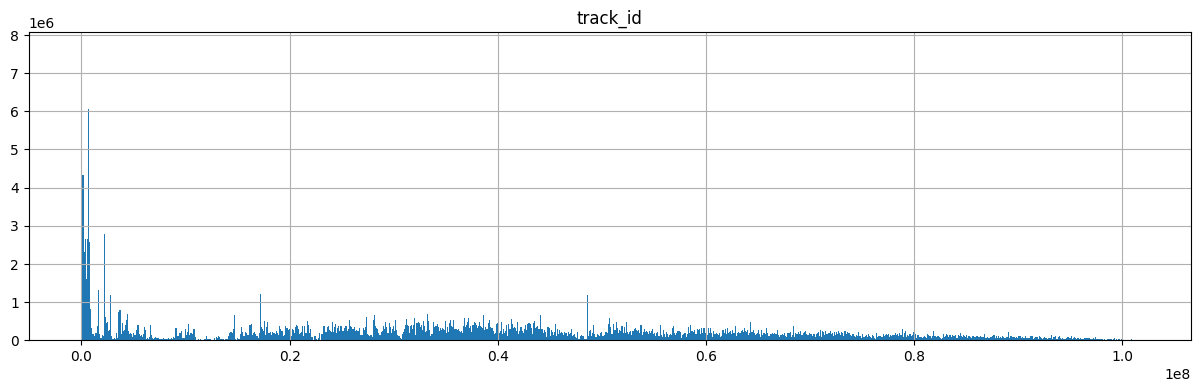

In [12]:
interactions.hist(column='track_id', bins=1000, figsize=(15,4))

In [13]:
top100tracks = tracks[tracks.track_id.isin(interactions.track_id.value_counts()[:100].index)]

Наиболее популярные треки

In [14]:
tracks_catalog = catalog_names[catalog_names.type=='track']
top100tracks_catalog = tracks_catalog[tracks_catalog.id.isin(top100tracks.track_id)]
top100tracks_catalog = top100tracks_catalog.rename({'id': 'track_id'}, axis=1)
def get_list(df, ids):
    return ', '.join(df[df.id.isin(ids)].name)
top100tracks['artists_names'] = top100tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
top100tracks['genres_names'] = top100tracks.apply(lambda row: get_list(genres, row.genres), axis=1)
top100tracks.merge(top100tracks_catalog, on='track_id')[['track_id', 'artists_names', 'name', 'genres_names']]

/tmp/ipykernel_132260/3775954581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100tracks['artists_names'] = top100tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
/tmp/ipykernel_132260/3775954581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top100tracks['genres_names'] = top100tracks.apply(lambda row: get_list(genres, row.genres), axis=1)


,track_id,artists_names,name,genres_names
0,10216,Scorpions,Wind Of Change,"hardrock, allrock"
1,37384,The Cranberries,Zombie,"rock, allrock"
2,48951,Bon Jovi,It's My Life,"rock, hardrock, allrock"
3,52100,No Doubt,Don't Speak,pop
4,53404,Nirvana,Smells Like Teen Spirit,"alternative, rock, allrock"
...,...,...,...,...
95,78426489,Minelli,Rampampam,dance
96,81848875,Galibri & Mavik,Федерико Феллини,"pop, ruspop"
97,83063895,HammAli & Navai,Птичка,"pop, ruspop"
98,84382282,"Markul, Джарахов",Я в моменте,"rusrap, rap"


Наиболее популярные жанры

In [15]:
# cм выше

Треки, которые никто не прослушал

In [16]:
tracks[~tracks.track_id.isin(interactions.track_id)]
# таких нет

,track_id,albums,artists,genres,albums_ok,genres_ok,artists_ok


In [17]:
interactions.groupby(['user_id', 'track_id'])['track_seq'].count().nunique()

1

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [18]:
tracks_catalog = tracks_catalog.rename({'id': 'track_id'}, axis=1)

In [19]:
tracks.merge(tracks_catalog, on='track_id')

,track_id,albums,artists,genres,albums_ok,genres_ok,artists_ok,type,name
0,26,"[3, 2490753]",[16],"[11, 21]",True,True,True,track,Complimentary Me
1,38,"[3, 2490753]",[16],"[11, 21]",True,True,True,track,Momma's Boy
2,135,"[12, 214, 2490809]",[84],[11],True,True,True,track,Atticus
3,136,"[12, 214, 2490809]",[84],[11],True,True,True,track,24 Hours
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],True,True,True,track,Don't Upset The Rhythm (Go Baby Go)
...,...,...,...,...,...,...,...,...,...
980965,101478482,[21399811],[5540395],"[3, 75]",True,True,True,track,На лицо
980966,101490148,[21403052],[9078726],"[11, 20]",True,True,True,track,Без капли мысли
980967,101493057,[21403883],[11865715],"[44, 75]",True,True,True,track,SKITTLES
980968,101495927,[21404975],[4462686],"[3, 75]",True,True,True,track,Москва


In [20]:
%%time
# tracks['artists_names'] = tracks.apply(lambda row: get_list(artists, row.artists), axis=1)
# tracks['genres_names'] = tracks.apply(lambda row: get_list(genres, row.genres), axis=1)
def apply_artists(artists_id):
    return  get_list(artists, artists_id)
def apply_genres(genres_id):
    return get_list(genres, genres_id)
with mp.Pool(mp.cpu_count()) as pool:
    tracks['artists_names'] = pool.map(apply_artists, tracks.artists)
    tracks['genres_names'] = pool.map(apply_genres, tracks.genres)
items = tracks.merge(tracks_catalog, on='track_id')

CPU times: user 5.71 s, sys: 1.02 s, total: 6.73 s
Wall time: 47.5 s


In [21]:
items = items.drop(['albums_ok', 'genres_ok', 'artists_ok', 'type'], axis=1)

In [22]:
items.sample(5)

,track_id,albums,artists,genres,artists_names,genres_names,name
874816,73536519,[12774689],[2423146],[335],Hinkstep,relax,Chasing The Dragon
177673,4907518,[542704],[298412],"[14, 102]",Jean-Pierre Danel,"rock, allrock",Misirlou
928512,84285672,"[15958514, 17244659]",[7064906],[13],Royal & The Serpent,alternative,fanny pack
758166,58901533,[8985825],[159015],"[11, 20]",Елена Темникова,"pop, ruspop",STRESS
155856,3949144,"[444582, 471837]",[678906],"[16, 68]",Samantha James,"dance, electronics",Illusions


In [23]:
%%time
interactions.started_at = interactions.started_at.apply(lambda ts: ts.date())

CPU times: user 1min 57s, sys: 7.73 s, total: 2min 5s
Wall time: 2min 5s


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [24]:
genres.to_parquet('genres.parquet')
artists.to_parquet('artists.parquet')
albums.to_parquet('albums.parquet')
events = interactions
events.to_parquet('events.parquet')
items.to_parquet('items.parquet')
top100tracks.to_parquet('top100.parquet')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Если есть желание можно перезапустить ядро, затем раскомментировать и выполнить ячейку ниже

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [25]:
# from datetime import datetime
# import multiprocessing as mp
# import pandas as pd
# import numpy as np
# import scipy
# import sklearn.preprocessing
# import sklearn.metrics
# from implicit.als import AlternatingLeastSquares
# from catboost import CatBoostClassifier, Pool
#
# genres = pd.read_parquet('genres.parquet')
# artists = pd.read_parquet('artists.parquet')
# albums = pd.read_parquet('albums.parquet')
# events = pd.read_parquet('events.parquet')
# items = pd.read_parquet('items.parquet')

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [26]:
train_test_global_time_split_date = pd.to_datetime('2022-12-16').date()  # this will not work with cudf
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# пользователи в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# пользователи, которые есть и в train и в test
common_users = set(users_train) & set(users_test)  # this will not work with cudf
print(len(users_train), len(users_test), len(common_users))

1342107 782025 751365


In [27]:
cold_users = set(users_test) - common_users
print(len(cold_users))

30660


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [28]:
item_popularity = events_train.groupby(["track_id"]).agg(users=("user_id", "nunique")).reset_index().sort_values(by='users', ascending=False)
item_popularity.head(10)
top_popular = item_popularity[:100]
top_popular.to_parquet('top_popular.parquet')

In [29]:
cold_users_events = events_test[events_test.user_id.isin(cold_users)]
len(set(cold_users_events[cold_users_events.track_id.isin(top_popular.track_id)].track_id) & set(top_popular.track_id))

100

# Персональные

Рассчитаем персональные рекомендации.

In [30]:
%%time
# перекодирование идентификаторов пользователей:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events["user_id_enc"] = user_encoder.transform(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
# перекодирование идентификаторов трэков:
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
events_test["track_id_enc"] =  item_encoder.transform(events_test["track_id"])

<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 1min 24s, sys: 716 ms, total: 1min 24s
Wall time: 1min 26s


<timed exec>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
# создание разряжённой матрицы формата CSR
user_item_matrix_train = scipy.sparse.csr_matrix((
    [1] * len(events_train),
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8)


In [32]:
%%time
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 28.4 s, sys: 413 ms, total: 28.8 s
Wall time: 29.6 s


In [33]:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=False, n=10):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
        user_id_enc,
        user_item_matrix[user_id_enc],
        filter_already_liked_items=not include_seen,
        N=n)
    recommendations = pd.DataFrame({"track_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["track_id"] = item_encoder.inverse_transform(recommendations["track_id_enc"])

    return recommendations

user_id = events_train['user_id'].sample().iat[0]
user_id_enc = user_encoder.transform([user_id])[0]
print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items.set_index("track_id"), on="track_id")
)
user_history_to_print = user_history[["track_id", "artists_names", "name", "genres_names", "started_at"]].tail(10)
display(user_history_to_print)

print("Рекомендации")
user_recommendations = get_recommendations_als(user_item_matrix_train, als_model, user_id, user_encoder, item_encoder)
user_recommendations = user_recommendations.merge(items[["track_id", "artists_names", "name", "genres_names", ]], on="track_id")
display(user_recommendations)

История (последние события, recent)


,track_id,artists_names,name,genres_names,started_at
241,78194999,SLAVA MARLOW,ТЫ ГОРИШЬ КАК ОГОНЬ,"rusrap, rap",2022-12-06
242,78210025,"Тайпан, Agunda",Мерцают огни,"pop, ruspop",2022-12-07
243,78336466,ФОГЕЛЬ,ДУРАКАМ ВЕЗЁТ,"pop, ruspop",2022-12-08
244,78608850,10AGE,Нету интереса,"rusrap, rap",2022-12-10
245,78619463,"NILETTO, Анет Сай",Не люблю?,"pop, ruspop",2022-12-11
246,78771795,Rakhim,Синий Lamborghini,"rusrap, rap",2022-12-11
247,78879876,NЮ,Я надеюсь,"pop, ruspop",2022-12-12
248,81848875,Galibri & Mavik,Федерико Феллини,"pop, ruspop",2022-12-13
249,85088913,"Klaas, Mister Ruiz",Feel Only Love,dance,2022-12-14
250,90660749,Клава Кока,ЛА ЛА ЛА,"pop, ruspop",2022-12-15


Рекомендации


,track_id_enc,score,track_id,artists_names,name,genres_names
0,754831,0.949982,58515506,GAYAZOV$ BROTHER$,Увезите меня на Дип-хаус,"pop, ruspop"
1,816204,0.674819,65591365,twocolors,Lovefool,dance
2,773816,0.671645,60725745,Мэвл,Патамушка,"pop, ruspop"
3,741143,0.670701,56776952,Макс Корж,2 типа людей,"rusrap, rap"
4,742433,0.648375,56920237,Zivert,Beverly Hills,"pop, ruspop"
5,849932,0.606942,70274628,Дора,Втюрилась,"local-indie, indie"
6,748889,0.580742,57799893,SAINt JHN,Roses,dance
7,624543,0.577364,43731470,Trevor Daniel,Falling,"pop, foreignrap, rap"
8,678849,0.573772,49961817,"Artik & Asti, Артём Качер",Грустный дэнс,"pop, ruspop"
9,737849,0.572967,56312027,Олег Кензов,По кайфу,"pop, ruspop"


In [34]:
%%time
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = events_train['user_id_enc'].unique()  # range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=False, N=100)


# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(),
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("als_recommendations.parquet")
als_recommendations.sample(5)

CPU times: user 6min 35s, sys: 1min 33s, total: 8min 8s
Wall time: 8min 9s


,user_id,item_id,score
1851248,18979,24442536,0.089693
77119202,789718,51516485,0.041511
42591806,436161,61638507,0.188723
101072853,1035057,2200971,0.064386
64334774,658888,33931,0.059942


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [35]:
%%time
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_track_ids_enc = events_train['track_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_track_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_track_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_track_ids_enc,
    "sim_track_id_enc": sim_item_track_ids_enc.tolist(),
    "score": sim_item_scores.tolist()})

similar_items = similar_items.explode(["sim_track_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_track_id_enc"] = similar_items["sim_track_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["track_id_1"] = item_encoder.inverse_transform(similar_items["track_id_enc"])
similar_items["track_id_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_enc"])
similar_items = similar_items.drop(columns=["track_id_enc", "sim_track_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("track_id_1 != track_id_2")

similar_items.to_parquet('similar_items.parquet')
similar_items.sample(5)

CPU times: user 22.6 s, sys: 627 ms, total: 23.2 s
Wall time: 24.2 s


,score,track_id_1,track_id_2
1447723,0.901696,52156077,37522572
1399060,0.923067,26013305,35929398
6778083,0.943518,67823419,4211687
2352605,0.944451,75663887,73198126
5384133,0.867947,23142991,6597399


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [36]:
%%time
def get_user_features(events):
    user_features = events.groupby('user_id').agg(
        tracks_total=('track_id', 'nunique'),
        hearing_days=('started_at', lambda x: (x.max() - x.min()).days),
    )
    user_features['tracks_per_day'] = user_features['tracks_total'] / user_features['hearing_days']
    return user_features

user_features_for_train = get_user_features(events_train)

CPU times: user 1min 15s, sys: 3.89 s, total: 1min 19s
Wall time: 1min 20s


In [37]:
events = events.rename(columns={'track_id': 'item_id'})
events_train = events_train.rename(columns={'track_id': 'item_id'})
events_test = events_test.rename(columns={'track_id': 'item_id'})

In [38]:
%%time
def get_item_features(events):
    items_features = events.groupby('item_id').agg(
        nusers=('user_id', 'nunique'),
    )
    return items_features

item_features_for_train = get_item_features(events_train)


CPU times: user 39.2 s, sys: 2.38 s, total: 41.6 s
Wall time: 41.8 s


In [39]:
# genre_names_to_id = genres.reset_index().set_index("name")["id"].to_dict()
# genre_names_to_id

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [40]:
split_date_for_labels = pd.to_datetime('2022-12-24').date()
split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()
events_labels.nunique()

user_id         697473
item_id         502028
track_seq        12850
started_at           8
user_id_enc     697473
track_id_enc    502028
dtype: int64

In [41]:
candidates = als_recommendations[["user_id", "item_id", "score"]]


In [42]:
%%time
# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прочитал
# — 0, для всех остальных

events_labels["target"] = 1

candidates = candidates.merge(events_labels[["user_id", "item_id", "target"]],
                              on=["user_id", "item_id"], how='left')

candidates["target"] = candidates["target"].fillna(0).astype("int")
#
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)
#
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates[candidates.target==1],
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
])
candidates_for_train.shape

CPU times: user 1min 23s, sys: 6.6 s, total: 1min 29s
Wall time: 1min 28s


<timed exec>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


(1167759, 4)

In [43]:
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")
candidates_for_train = candidates_for_train.merge(item_features_for_train, on="item_id", how="left")

In [44]:
candidates_for_train.sample(5)


,user_id,item_id,score,target,tracks_total,hearing_days,tracks_per_day,nusers
701417,547689,47627256,0.382794,0,68,21,3.238095,72164
378578,1327678,35785893,0.181291,1,60,119,0.504202,19059
87669,307911,46477076,0.035880,1,45,83,0.542169,18244
540295,262815,32555567,0.012577,0,41,76,0.539474,11327
270558,949367,53281724,0.028061,1,21,4,5.250000,18673


In [45]:
%%time
# задаём имена колонок признаков и таргета
features = ['score',
            'tracks_total', 'hearing_days', 'tracks_per_day',
            'nusers']
target = 'target'

# создаём Pool
train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=True,
    random_seed=0,
    task_type='GPU'
)

# тренируем модель
cb_model.fit(train_data)



0:	learn: 0.6770205	total: 32.2ms	remaining: 32.1s
1:	learn: 0.6639937	total: 37.4ms	remaining: 18.7s
2:	learn: 0.6533900	total: 43.2ms	remaining: 14.4s
3:	learn: 0.6449556	total: 49.5ms	remaining: 12.3s
4:	learn: 0.6380731	total: 55.6ms	remaining: 11.1s
5:	learn: 0.6324234	total: 60.8ms	remaining: 10.1s
6:	learn: 0.6278595	total: 64.4ms	remaining: 9.14s
7:	learn: 0.6241284	total: 68.1ms	remaining: 8.44s
8:	learn: 0.6209653	total: 71.8ms	remaining: 7.91s
9:	learn: 0.6182247	total: 75.4ms	remaining: 7.47s
10:	learn: 0.6161158	total: 79ms	remaining: 7.1s
11:	learn: 0.6143048	total: 82.7ms	remaining: 6.8s
12:	learn: 0.6127291	total: 86.1ms	remaining: 6.54s
13:	learn: 0.6113424	total: 89.5ms	remaining: 6.3s
14:	learn: 0.6102749	total: 92.7ms	remaining: 6.09s
15:	learn: 0.6093867	total: 96ms	remaining: 5.9s
16:	learn: 0.6084784	total: 99.4ms	remaining: 5.75s
17:	learn: 0.6077719	total: 103ms	remaining: 5.6s
18:	learn: 0.6065593	total: 106ms	remaining: 5.47s
19:	learn: 0.6060385	total: 109ms

In [46]:
candidates_to_rank = als_recommendations[als_recommendations["user_id"].isin(events_test["user_id"].drop_duplicates())]
print(len(candidates_to_rank))
candidates_to_rank = candidates_to_rank.merge(user_features_for_train, on="user_id", how="left")
candidates_to_rank = candidates_to_rank.merge(item_features_for_train, on="item_id", how="left")

75136500


In [47]:
%%time
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["score"] = predictions[:,1]

# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby('user_id').cumcount() + 1

max_recommendations_per_user = 100
# final_recommendations = candidates_to_rank.query("rank >= @max_recommendations_per_user")
final_recommendations = candidates_to_rank

final_recommendations.to_parqueet('recommendations.parquet')
print(len(final_recommendations), len(candidates_to_rank))
final_recommendations.sample(5)


75136500 75136500
CPU times: user 1min 44s, sys: 3.15 s, total: 1min 48s
Wall time: 55.8 s


,user_id,item_id,score,tracks_total,hearing_days,tracks_per_day,nusers,rank
47170209,863353,62208587,0.277034,719,186,3.865591,35023,23
20868824,381457,18088710,0.247206,6,20,0.300000,8536,8
70406839,1288192,28006258,0.349736,6,19,0.315789,16118,66
53924838,987001,50685843,0.145627,10,239,0.041841,66321,81
66982586,1225965,41625041,0.308999,247,43,5.744186,32008,65


In [48]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")

    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train,
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)

    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]],
        on=["user_id", "item_id"], how="outer")

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()

    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common


def compute_cls_metrics(events_recs_for_binary_metric):

    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()

    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall


In [49]:
events_inference = pd.concat([events_train, events_labels])
events_inference.target = events_inference.target.fillna(0).astype(int)

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations,
    top_k=5)
cb_events_recs_for_binary_metrics_5.score = cb_events_recs_for_binary_metrics_5.score.fillna(0).astype(int)
cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

Common users: 540276


/tmp/ipykernel_132260/2491400055.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


precision: 0.006, recall: 0.009


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [50]:
top100tracks_train = tracks[tracks.track_id.isin(events_train.item_id.value_counts()[:100].index)]
cold_users_events = events_test[events_test["user_id"].isin(cold_users)]
cold_users_events[cold_users_events.item_id.isin(top100tracks_train.track_id)].item_id.nunique()
# все 100 из top100 трэков слушали холодные пользователи

100

In [54]:
def compute_ndcg(rating: pd.Series, score: pd.Series, k):
    if len(rating) < 2:
        return np.nan
    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)
    return ndcg

rating_test_idx = ~als_recommendations['score'].isnull()
ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['score'], x["score"], k=5))
print(ndcg_at_5_scores.mean())

1.0


/tmp/ipykernel_132260/198622621.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg_at_5_scores = als_recommendations[rating_test_idx].groupby('user_id').apply(lambda x: compute_ndcg(x['score'], x["score"], k=5))


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

In [ ]:
#разметим каждую рекомендацию признаком read
events_train["heard"] = True
als_recommendations = als_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
als_recommendations["heard"] = als_recommendations["heard"].fillna(False).astype("bool")

# проставим ранги
als_recommendations = als_recommendations.sort_values(by='score', ascending=False)
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1-als_recommendations.query("rank <= 5").groupby("user_id")["heard"].mean())
#
# посчитаем средний novelty
novelty_5 = novelty_5.mean()
novelty_5

In [ ]:
feature_importance = pd.DataFrame(cb_model.get_feature_importance(),
                                  index=features,
                                  columns=["fi"])
feature_importance = feature_importance.sort_values(by='fi', ascending=False)

print(feature_importance )
